Unit 10, Lecture 2
====

*Numerical Methods and Statistics*

----

#### Prof. Andrew White, Mar 31 2016

In [1]:
%matplotlib inline
import random
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt, pi, erf
import scipy.stats
import scipy.linalg as linalg
plt.style.use('ggplot')
import matplotlib
matplotlib.rcParams['figure.figsize'] = (7,5)

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Linearizing An Exponential
---

We previously learned how to linearize polynomials into OLS-ND. What about a more complex equation, like:

$$y = \beta_0 e^{-\beta_1 x^2} + \epsilon $$

Well, you could of course just do this:

$$\ln y = \ln\beta_0 - \beta_1 x^2 + \epsilon $$

and then choose our $x$ matrix to be $[1,-x^2]$

**But we just changed our assumption of noise!** To do the math I just above, it should have been that our original equation was:
$$y = \beta_0 e^{-\beta_1 x^2}\times e^{\epsilon} $$ so that after taking the log, we ended up with that above. But that equation doesn't our assumption that we have normally distributed 0-centered noise.

Can we neglect our assumption of linear normal noise?
===

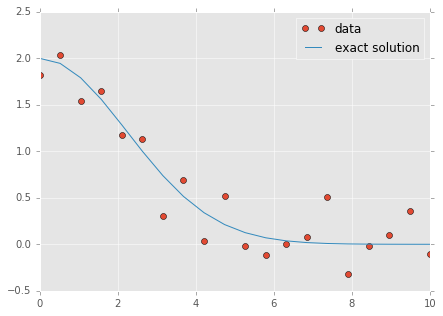

In [2]:
#Make up an equation and create data from it
x = np.linspace(0, 10, 20)
y = 2 * np.exp(-x**2 * 0.1) + scipy.stats.norm.rvs(size=len(x), loc=0, scale=0.2)

plt.plot(x,y, 'o', label='data')
plt.plot(x, 2 * np.exp(-x**2 * 0.1), '-', label='exact solution')
plt.legend(loc='upper right')
plt.show()

In [3]:
#Now we compute the least squares solution

x_mat = np.column_stack( (np.ones(len(x)), -x**2) )

#Any negative y-values will not work, since log of a negative number is undefined
y_clean = []
for yi in y:
    if yi < 0:
        y_clean.append(0.0000001)
    else:
        y_clean.append(yi)

lin_y = np.log(y_clean)


lin_beta = linalg.inv( x_mat.transpose().dot(x_mat) ).dot( x_mat.transpose() ).dot( lin_y )
print(lin_beta)
beta_0 = np.exp(lin_beta[0])
beta_1 = lin_beta[1]

print(beta_0, 2)
print(beta_1, 0.1)

[-0.94825922  0.11179528]
(0.38741484241615076, 2)
(0.11179528210390666, 0.1)


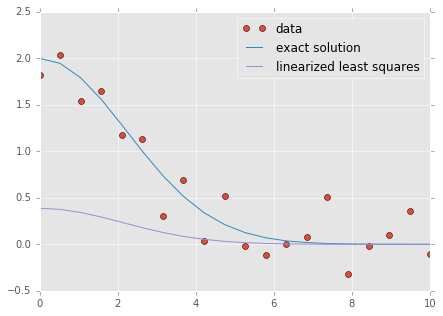

In [4]:
plt.plot(x,y, 'o', label='data')
plt.plot(x, 2 * np.exp(-x**2 * 0.1), '-', label='exact solution')
plt.plot(x, beta_0 * np.exp(-x**2 * beta_1), '-', label='linearized least squares')
plt.legend(loc='upper right')
plt.show()

**NO, we cannot linearize and ignore the impact on noise**

Checking if Linearization is Valid
====

The way to check if the linearization is valid is to see if the residuals are normally distributed. Since you are assuming the noise is normal after linearization, you can check that assumption:

In [5]:
resids = y - beta_0 * np.exp(-x**2 * beta_1)
scipy.stats.shapiro(resids)

(0.901792049407959, 0.044561151415109634)

The Shapiro-Welk test says absolutely not are they normal, as we can imagine from looking at the graph.

Nonlinear Multidimensional Least-Squares
====

To treat things like the exponential distribution from above, we need to use an objective function and minimization. We'll minimize the SSR directly:

$$SSR = \sum_i (\hat{y}_i - y_i)^2 $$

$$SSR = \sum_i (\beta_0 e^{-\beta_1 x^2} - y_i)^2 $$

So our SSR is a function which takes in $(\beta_0, \beta_1)$

We're going to use a new technique this time. Instead of relying on the data being defined, we'll have our SSR take that as extra arguments and we'll tell the minimizer about these extra args.

In [6]:
#Create an objective function, that takes in 1 D-dimensional argument and outputs a measure of the goodness of fit (SSR)
def obj(beta, x, y):
    beta_0 = beta[0] #<- extract the elements of the beta vector
    beta_1 = beta[1]
    yhat = beta_0 * np.exp(-beta_1 * x**2) # <- This is our model equation
    resids = yhat - y #<- compute residuals
    SSR = np.sum(resids**2) #<- square and sum them
    return SSR

#Use the minimize (BGFS) function, with starting points
result = scipy.optimize.minimize(obj, x0=[1,1], args=(x, y))
beta_opt = result.x #<- remember, we get out a whole bunch of extra stuff from optimization
print(result)

   status: 0
  success: True
     njev: 15
     nfev: 60
 hess_inv: array([[ 0.16887774,  0.01203473],
       [ 0.01203473,  0.00297132]])
      fun: 1.0678498858017098
        x: array([ 1.93081608,  0.10598444])
  message: 'Optimization terminated successfully.'
      jac: array([ -1.63912773e-07,   5.99026680e-06])


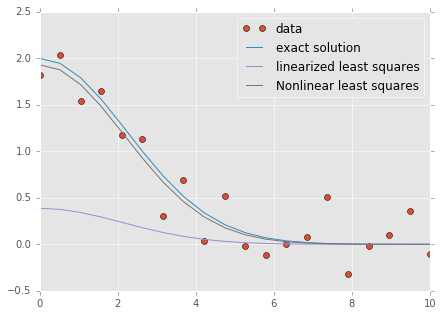

In [7]:
plt.plot(x,y, 'o', label='data')
plt.plot(x, 2 * np.exp(-x**2 * 0.1), '-', label='exact solution')
plt.plot(x, beta_0 * np.exp(-x**2 * beta_1), '-', label='linearized least squares')
plt.plot(x, beta_opt[0] * np.exp(-x**2 * beta_opt[1]), '-', label='Nonlinear least squares')
plt.legend(loc='upper right')
plt.show()

Error Analysis in Nonlinear Least Squares
====

Just like for the one-dimensional and multidimensional case, there exists an expression to go from standard error in the residuals to standard error for the fit. That expression is:

$$y = f(\beta, x) + \epsilon$$

$$ F_{ij} = \frac{\partial f(\hat{\beta}, x_i)}{\partial \hat{\beta_j}}$$

$$S^2_{\beta_{ij}} = S^2_{\epsilon}\left(\mathbf{F}^T\mathbf{F}\right)^{-1}$$

where again, the standard error for the $i$th given fit parameter is $S^2_{\beta{ii}}$

Take a close look at the partial derivatives. $x_i$ can be a vector here and remember that you're taking the partial with respect to the fit parameters, not $x$

Example: Error Analysis for Exponential Fit in Nonlinear Least Squares
----

To do the analysis, we must first compute the partial derivatives. Recall the model is:

$$y = \beta_0 e^{-\beta_1 x^2} + \epsilon $$

So that 

$$f(\beta, x) = \beta_0 e^{-\beta_1 x^2}$$

$$\frac{\partial f}{\partial \beta_0} = e^{-\beta_1 x^2}$$
$$\frac{\partial f}{\partial \beta_1} = -\beta_0 x^2 e^{-\beta_1 x^2}$$

To compute $\mathbf{F}$, we'll need to compute these functions at various points, so it's best to create a python function

In [8]:
def build_F(beta, x):
    #Compute the individual partials for each data point
    beta_0_vec = np.exp(-beta[1] * x**2)
    beta_1_vec = beta[0] * x**2 * np.exp(-beta[1] * x**2)
    #Now stack them together
    return np.column_stack( (beta_0_vec, beta_1_vec) )

print(build_F(beta_opt, x))

[[  1.00000000e+00   0.00000000e+00]
 [  9.71068205e-01   5.19377869e-01]
 [  8.89198943e-01   1.90235969e+00]
 [  7.67799120e-01   3.69593075e+00]
 [  6.25166577e-01   5.34994651e+00]
 [  4.80002348e-01   6.41825660e+00]
 [  3.47528512e-01   6.69154876e+00]
 [  2.37266808e-01   6.21822989e+00]
 [  1.52750628e-01   5.22873564e+00]
 [  9.27317575e-02   4.01741980e+00]
 [  5.30851985e-02   2.83927299e+00]
 [  2.86561518e-02   1.85454316e+00]
 [  1.45868582e-02   1.12346089e+00]
 [  7.00172619e-03   6.32886065e-01]
 [  3.16918764e-03   3.32229147e-01]
 [  1.35266500e-03   1.62782036e-01]
 [  5.44417430e-04   7.45427983e-02]
 [  2.06620429e-04   3.19377860e-02]
 [  7.39458770e-05   1.28142349e-02]
 [  2.49548026e-05   4.81831342e-03]]


Now to actually compute the standard error:

In [9]:
#The code below is our normal way of computing the standard error in the noise
resids = y - beta_opt[0] * np.exp(-x**2 * beta_opt[1])
SSR = np.sum(resids**2)
s2_epsilon = SSR / (len(x) - len(beta_opt))
print(s2_epsilon)

0.0593249936557


In [10]:
#Using our F, compute the standard error in beta
F = build_F(beta_opt, x)

s2_beta = s2_epsilon * linalg.inv(F.transpose().dot(F))
print(s2_beta)

[[ 0.02019086 -0.00147773]
 [-0.00147773  0.00036881]]


In [11]:
#We have standard error and can now compute a confidence interval
T = scipy.stats.t.ppf(0.975, len(x) - len(beta_opt))
c0_width = T * np.sqrt(s2_beta[0,0])
print('95% confidence interval for beta_0 is {} +/ {}'.format(beta_opt[0], c0_width))

c1_width = T * np.sqrt(s2_beta[1,1])
print('95% confidence interval for beta_1 is {} +/ {}'.format(beta_opt[1], c1_width))

95% confidence interval for beta_0 is 1.93081608276 +/ 0.298529548372
95% confidence interval for beta_1 is 0.105984442649 +/ 0.0403471793843


Of course, we could continue on and do hypothesis tests

A Complete & Complex Example - Deconvolution of Spectroscopy
===

In spectroscopy and chromatography, often we have a spectrum that is a mixture of peaks and we'd like to spearate them out. For example, here's a plot of a spectrum

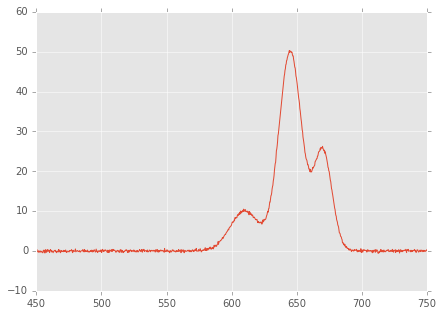

In [12]:
data = np.genfromtxt('spectrum.txt')

plt.plot(data[:,0], data[:,1])
plt.show()

You can see that there are probably 3 peaks in here. What we'd like to find out is what percentage each peak contributes. For example, this would tell us the amount of absorbance contributed by each of these three bonds or perhaps the amount of each compound in chromatography. 

The equation for each peak is:

$$ f(x, a, b, c) = \frac{a}{\sqrt{2 c \pi}}\,e^{-(x - b)^2 / c} $$

and the total spectrum is 

$$ f(x_i, \vec{a}, \vec{b}, \vec{c}) = \sum_j^M \frac{a_j}{\sqrt{2 \pi c_j}} e^{-(x_i - b_j)^2 / c_j} $$

where $j$ is the index of peak and runs from $1$ to $M$ where $M$ is the number of peaks.

Let's start by writing an equation that can predict a spectrum given some parameters

In [13]:
def peak(x, a, b, c):
    '''computes the peak equation for given parameters'''
    return a / np.sqrt(2 * np.pi * c) * np.exp(-(x - b)**2 / c)
def spectrum(x, a_array, b_array, c_array):
    '''Takes in the x data and parameters for a set of peaks. Computes spectrum'''
    yhat = np.zeros(np.shape(x))
    for i in range(len(a_array)):
        yhat += peak(x, a_array[i], b_array[i], c_array[i])
    return yhat
        

It's always good to test your functions, so let's do that

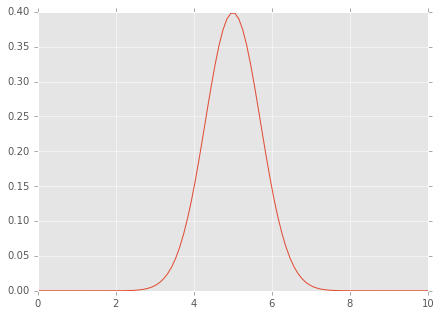

In [14]:
x = np.linspace(0, 10, 100)
y = peak(x, 1, 5, 1)
plt.plot(x,y)
plt.show()

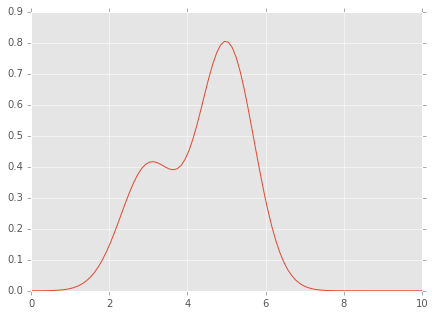

In [15]:
y = spectrum(x, [1, 2], [3, 5], [1,1])
plt.plot(x,y)
plt.show()

Ok! Now let's do the regression

Justifying a regression
---

Let's first test if there is a correlation

In [16]:
spec_x = data[:,0]
spec_y = data[:,1]

scipy.stats.spearmanr(spec_x, spec_y)

(0.34909264909264914, 4.933615809540912e-30)

Looks like there is a correlation, as indicated by the $p$-value. 

Computing the SSR
---

Let's write our SSR function

In [17]:
def spec_ssr(params, data, M):
    '''Compute SSR given the parameters, data, and number of desired peaks.'''
    x = data[:,0]
    y = data[:,1]
    a_array = params[:M]
    b_array = params[M:2*M]
    c_array = params[2*M:3 * M]
    yhat = spectrum(x, a_array, b_array, c_array)
    return np.sum((yhat - y)**2)

In [18]:
def obj(params):
    return spec_ssr(params, data=data, M=3)

Optimizing
---

Now we need to think aobut if this is non-convex! It is in fact non-convex, because there are many local minimums. This means we'll have to be smart about our starting parameters and/or run for many interations

In [19]:
import scipy.optimize as opt

result = opt.basinhopping(obj, x0=[100, 100, 100, 600, 650, 700, 100, 100, 100], niter=100)
print(result.x)

[  622.19584932  2441.89926287  -495.16685778   644.35134296   658.37917317
   692.58922075    66.32643591  1732.42691031   239.99142383]


Let's see if 100 iterations gave us good data!

In [20]:
def spec_yhat(params, data, M):
    '''compute the yhats for the spectrum problem'''
    x = data[:,0]
    a_array = params[:M]
    b_array = params[M:2*M]
    c_array = params[2*M:3 * M]
    return spectrum(x, a_array, b_array, c_array)


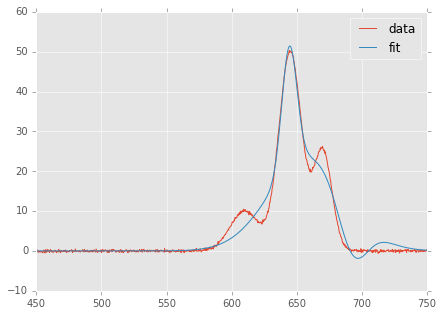

In [21]:
plt.plot(spec_x, spec_y, label='data')
plt.plot(spec_x, spec_yhat(result.x, data, 3), label='fit')
plt.legend()
plt.show()

What a good fit! Let's try plotting the individual peaks

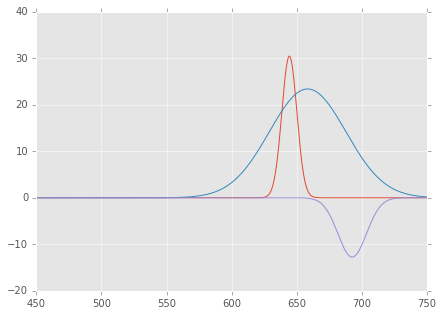

In [22]:
for i in range(3):
    plt.plot(spec_x, peak(spec_x, result.x[i], result.x[i + 3], result.x[i + 6]))

Wow, that is really wrong! As you saw in lecture, we can hit on particular peaks, but they usually have no meaning. Let's try to add more info. What info do we have? The peak centers. Let's try adding some constraints describing this info:

Adding constraints describing what we know:

$$ 600 < b_1 < 630 $$

$$ 630 < b_2 < 650 $$

$$ 650 < b_3 < 690 $$


In [23]:
#constraints follow the order above:

constraints = [{'type': 'ineq', 'fun': lambda params: params[3] - 600},
              {'type': 'ineq', 'fun': lambda params: 630 - params[3]},
              {'type': 'ineq', 'fun': lambda params: params[4] - 630},
              {'type': 'ineq', 'fun': lambda params: 650 - params[4]},
              {'type': 'ineq', 'fun': lambda params: params[5] - 650},
              {'type': 'ineq', 'fun': lambda params: 690 - params[5]}]
minimizer_kwargs = {'constraints': constraints}


In [ ]:
result = opt.basinhopping(obj, x0=[100, 100, 100, 600, 650, 700, 100, 100, 100], niter=350, minimizer_kwargs=minimizer_kwargs)
print(result.x)

/usr/lib/python2.7/dist-packages/scipy/optimize/_minimize.py:326: RuntimeWarning: Method BFGS cannot handle constraints nor bounds.
  RuntimeWarning)
/usr/lib/python2.7/dist-packages/scipy/optimize/optimize.py:880: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


In [ ]:
plt.plot(spec_x, spec_y, label='data')
plt.plot(spec_x, spec_yhat(result.x, data, 3), label='fit')
for i in range(3):
    plt.plot(spec_x, peak(spec_x, result.x[i], result.x[i + 3], result.x[i + 6]), label='peak {}'.format(i))
plt.legend()
plt.show()

Checking residuals
---

In [ ]:
resids = spec_y - spec_yhat(result.x, data, 3)
plt.hist(resids)
plt.show()
scipy.stats.shapiro(resids)

Looks like they are normal

Computing Standard Error
---

We need the partials:

$$\frac{\partial f}{\partial a} = \frac{1}{\sqrt{2 \pi c}}e^{-(x - b)^2 / c}$$

$$\frac{\partial f}{\partial b} = \frac{2a(x - b)}{c\sqrt{2 \pi c}} e^{-(x - b)^2 / c}$$

$$\frac{\partial f}{\partial c} = \frac{a}{\sqrt{2 \pi}}e^{-(x - b)^2 / c}\left[\frac{(x - b)^2}{c^{5/2}} - \frac{1}{2c^{3/2}}\right]$$

In [54]:
def peak_partials(x, a, b, c):
    '''Returns partial derivatives of peak functions with respect to parameters as a tuple'''
    return (1 / (np.sqrt(2 * np.pi * c)) * np.exp(-(x - b)**2 / c), \
            2 * a * (x - b) / c / np.sqrt(2 * np.pi * c) * np.exp(-(x - b)**2 / c),\
            a / np.sqrt( 2 * np.pi) * np.exp(-(x - b)**2 / c) * ((x - b)**2 / c**(5 / 2) - 1 / 2 / c**(3/2)))

We have to decide how we want to build the ${\mathbf F}$ matrix. I want to build it as 

$$\left[\frac{\partial f}{\partial a_1}, \frac{\partial f}{\partial a_2}, \frac{\partial f}{\partial a_3}, \frac{\partial f}{\partial b_1}, \ldots\right]$$

In [55]:
def spectrum_partials(x, a_array, b_array, c_array):
    '''Takes in the x data and parameters for a set of peaks. Computes partial derivatives and returns as matrix'''
    result = np.empty( (len(x), len(a_array) * 3 ) )
    for i in range(len(a_array)):
        a_p, b_p, c_p = peak_partials(x, a_array[i], b_array[i], c_array[i])
        result[:, i] = a_p
        result[:, i  + 3] = b_p
        result[:, i + 6] = c_p
    return result

In [56]:
M = 3
F = spectrum_partials(spec_x, result.x[:M], result.x[M:2*M], result.x[2*M:3*M])
print(F)

[[  5.96151669e-047   3.41062370e-112   4.22555832e-214 ...,
    9.71187136e-045   8.81611972e-109   1.29617757e-210]
 [  8.76415318e-047   7.43524023e-112   1.60019733e-213 ...,
    1.42238266e-044   1.91600850e-108   4.89515353e-210]
 [  1.28750456e-046   1.61895433e-111   6.04885392e-213 ...,
    2.08167289e-044   4.15904573e-108   1.84534094e-209]
 ..., 
 [  3.43344309e-036   9.93848316e-034   9.92420182e-030 ...,
    4.23814705e-034   7.32534250e-031   3.93737756e-027]
 [  2.45271893e-036   6.54242082e-034   6.13009825e-030 ...,
    3.04071172e-034   4.85018895e-031   2.45066500e-027]
 [  1.75085964e-036   4.30165164e-034   3.77963094e-030 ...,
    2.17999755e-034   3.20745430e-031   1.52250357e-027]]


Now we compute all the confidence intervals

In [67]:
SSR = np.sum(resids**2)
s2_epsilon = SSR / (len(spec_x) - len(result.x))
s2_beta = np.diag(s2_epsilon * linalg.inv(F.transpose().dot(F)))
ci = np.sqrt(s2_beta) * scipy.stats.norm.ppf(0.975)

for pi, c in zip(result.x, ci):
    print('{} +/- {}'.format(pi, c))

396.9366271236392 +/- 2.9053459377655435
1535.8730967352235 +/- 3.726908246626489
623.8528115345109 +/- 2.910011867594273
610.009143488247 +/- 0.09042309391437897
645.0092538945211 +/- 0.018911755268546826
670.0049354023511 +/- 0.03502567752433928
249.15702525247494 +/- 4.418070075799146
150.16955198524047 +/- 0.8458174064030757
99.16552904274009 +/- 0.9623327268867067


The relative populations, the integrated peaks, are just the $a$ values. I'll normalize them into percent:

In [69]:
for pi, c in zip(result.x[:3], ci[:3]):
    print('{:%} +/- {:%}'.format(pi / np.sum(result.x[:3]), c / np.sum(result.x[:3])))

15.525578% +/- 0.113638%
60.073360% +/- 0.145772%
24.401062% +/- 0.113821%


In [ ]:
%system jupyter nbconvert Unit_11_Lecture_2.ipynb --to slides --post serve